## PSF Modeling

PSF modeling with *SExtractor* and *PSFExtractor* consists of three steps:

- Preprocessing: It requires decompressing the CompImageHDU with the image and then store it in uncompressed (.fits) format for further processing. HDUs 2 and 3 corresponding to Image mask and weights, respectively, do not seem to interact well with PSFExtractor, and so I only keep HDU 1 (the actual image) and HDU 0 (metadata).

- SExtractor: Run *SExtractor* software with *config.sex* for configuration parameters and *config.param* for the output parameters. The parameter file name is specified in *config.sex*, and so the command for running it looks like:

                source-extractor path/to/uncompressed-image.fits -c config.sex

- PSFExtractor: Run *PSFExtractor* with the values in *config.psfex*. Running it looks like this:

                psfex path/to/sextractor-catalog.cat -c config.psf

Both parameters and parameter values are obtained from: https://arxiv.org/pdf/1801.03177.

I have also added a small subsection on postprocessing, where I draw a small image from the resulting PSF. Hope it's useful.

In [1]:
from astropy.io import fits
import numpy as np
import os
import subprocess

## Preprocessing

In [22]:
# Open the original FITS file with compressed HDUs
filepath = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/'
compressed_filename = 'DES0000+0209_r4907p01_r_nobkg.fits.fz'
uncompressed_filename = 'DES0000+0209_r4907p01_r_nobkg_decompressed.fits'
save_hdu = 1

with fits.open(filepath + compressed_filename) as hdul:
    # Create a new HDUList to store the decompressed HDUs
    decompressed_hdul = fits.HDUList()
    
    # Loop over each HDU in the original file
    for (i,hdu) in enumerate(hdul):
        # Check if the HDU is a compressed image and decompress it
        if isinstance(hdu, fits.CompImageHDU):
            decompressed_data = hdu.data  # Access the decompressed data
            decompressed_header = hdu.header  # Copy the header
            # Create a new ImageHDU with the decompressed data
            new_hdu = fits.ImageHDU(data=decompressed_data, header=decompressed_header)
            decompressed_hdul.append(new_hdu)
            # Exit after the HDU 1, in this case.
            if i == save_hdu:
                break
        else:
            # If it's not a compressed HDU, just copy it over
            decompressed_hdul.append(hdu)
        

    # Save the decompressed file
    decompressed_hdul.writeto(filepath + uncompressed_filename, overwrite=True)


In [2]:
def decompress_hdu(filepath, savepath):
    """
    Decompress HDU for SExtractor processing.
    """
    with fits.open(filepath) as hdul:
        decompressed_hdul = fits.HDUList()
        for (i,hdu) in enumerate(hdul):
            if isinstance(hdu, fits.CompImageHDU):
                #Only save HDU 0 and HDU 1
                if i != 1:
                    continue
                decompressed_data = hdu.data  
                decompressed_header = hdu.header
                new_hdu = fits.ImageHDU(data=decompressed_data, header=decompressed_header)
                decompressed_hdul.append(new_hdu)
                
            else:
                decompressed_hdul.append(hdu)
        decompressed_hdul.writeto(savepath, overwrite=True)



def sample_tiles(path_to_tiles, n_samples_per_band=100, seed=42):
    """
    Sample n_samples_per_band tiles to model with SExtractor.
    """
    np.random.seed(seed)
    samples = np.random.choice(os.listdir(path_to_tiles), size=n_samples_per_band)
    return samples

In [3]:
TILE_PATHS = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles'
DES_BANDS = ("g", "r", "i", "z")
SAVE_PATH = '/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles'
CONFIG_PATH = '/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/config'

tile_paths = sample_tiles(TILE_PATHS, n_samples_per_band=10169)
from tqdm import tqdm
suma = 0
full = []
for tile in tqdm(tile_paths):
    len_tilepath = len(os.listdir(f"{SAVE_PATH}/{tile}"))
    if len_tilepath == 8:
        suma +=1
        full.append(tile)

  0%|          | 0/10169 [00:00<?, ?it/s]

100%|██████████| 10169/10169 [00:18<00:00, 548.84it/s]


In [37]:
full

['DES0026-4831',
 'DES0244-4206',
 'DES2350-5957',
 'DES0104-3457',
 'DES0441-4957',
 'DES2253-4206',
 'DES0126-3706',
 'DES0541-4831',
 'DES2251-4414',
 'DES0000+0418',
 'DES0322-6122',
 'DES0018-3706',
 'DES0257-3040',
 'DES0211-1541',
 'DES2053-4457',
 'DES0519-4831',
 'DES0152-2623',
 'DES0252-4331',
 'DES0458-1749',
 'DES0153-2458',
 'DES2121-4957',
 'DES2109-4206',
 'DES0509-3623',
 'DES0110-0541',
 'DES2139-5205',
 'DES0019-0124',
 'DES0515-6122',
 'DES0046-4957',
 'DES2003-5248',
 'DES2024-4249',
 'DES0118-4623',
 'DES0257-3623',
 'DES0101-3206',
 'DES0050-0541',
 'DES0452-5205',
 'DES0445-3540',
 'DES2228-0124',
 'DES0621-5457',
 'DES0453-5248',
 'DES0220-3957',
 'DES0416-5457',
 'DES2053-5331',
 'DES0321-2415',
 'DES0208+0043',
 'DES0118-3415',
 'DES2011-5540',
 'DES2253-5831',
 'DES0443-1915',
 'DES0257-2332',
 'DES2041-5540',
 'DES0534-4623',
 'DES0410-1749',
 'DES0521-4957',
 'DES0205-3332',
 'DES2123-6414',
 'DES0046-0458',
 'DES2310-5914',
 'DES0310-2206',
 'DES0624-4331

In [26]:
os.listdir(f"{SAVE_PATH}/{full[2]}")

['DES2350-5957_r4907p01_g_nobkg.cat',
 'DES2350-5957_r4907p01_i_nobkg.cat',
 'DES2350-5957_r4907p01_i_nobkg.psf',
 'DES2350-5957_r4907p01_z_nobkg.psf',
 'DES2350-5957_r4907p01_r_nobkg.psf',
 'DES2350-5957_r4907p01_r_nobkg.cat',
 'DES2350-5957_r4907p01_z_nobkg.cat',
 'DES2350-5957_r4907p01_g_nobkg.psf']

In [4]:
suma

3545

In [29]:
suma

3330

In [30]:
suma

3330

In [8]:
os.listdir(f"{TILE_PATHS}/{tile}")

['DES0055-4457_dr2_magnitude.fits',
 'DES0055-4457_r4907p02_r_nobkg.fits.fz',
 'DES0055-4457_r4907p02_i_nobkg.fits.fz',
 'DES0055-4457_r4907p02_Y_nobkg.fits.fz',
 'DES0055-4457_r4907p02_z_nobkg.fits.fz',
 'DES0055-4457_dr2_main.fits',
 'DES0055-4457_dr2_flux.fits',
 'DES0055-4457_r4907p02_g_nobkg.fits.fz']

In [21]:
TILE_PATHS = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles'
DES_BANDS = ("g", "r", "i", "z")
SAVE_PATH = '/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles'
CONFIG_PATH = '/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/config'

tile_paths = sample_tiles(TILE_PATHS, n_samples_per_band=2)


for tile in tile_paths:
    ## Define directories where data will be stored
    save_dir = f"{SAVE_PATH}/{tile}"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    dir_files = {
            band: [
                f for f in os.listdir(f"{TILE_PATHS}/{tile}") if f.endswith(f"{band}_nobkg.fits.fz")
            ][0]
            for band in DES_BANDS
        }
    
    for band, filename in dir_files.items():
        # Where you read it from, in gapatron desdr dir
        filepath = f"{TILE_PATHS}/{tile}/{filename}"
        # Where you save it in gapatron psf-models/dir
        savepath = f"{SAVE_PATH}/{tile}/{filename}".replace(".fits.fz", ".fits")

        print(f"Decompressing: {filepath}")
        decompress_hdu(filepath, savepath)
        print(f"Success! Saved at: {savepath}")

        savecatpath = savepath.replace(".fits", ".cat")

        subprocess.run(["sed", "-i", f"s|^CATALOG_NAME\s*.*|CATALOG_NAME     {savecatpath}|", f"{CONFIG_PATH}/config.sex"])
        subprocess.run(["source-extractor", savepath, "-c", f"{CONFIG_PATH}/config.sex"])
        subprocess.run(["psfex", f"{savecatpath}", "-c", f"{CONFIG_PATH}/config.psfex"])
        


Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_g_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_g_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:17:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0112-2458_r4907p01_g_nobkg.fits
----- Measuring from: DES0112-2458_r4907p01_g_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_r_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_r_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:17:56 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0112-2458_r4907p01_r_nobkg.fits
----- Measuring from: DES0112-2458_r4907p01_r_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_i_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_i_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:18:24 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0112-2458_r4907p01_i_nobkg.fits
----- Measuring from: DES0112-2458_r4907p01_i_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_z_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0112-2458/DES0112-2458_r4907p01_z_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:18:49 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0112-2458_r4907p01_z_nobkg.fits
----- Measuring from: DES0112-2458_r4907p01_z_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_g_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_g_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:19:10 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0342-1415_r4931p01_g_nobkg.fits
----- Measuring from: DES0342-1415_r4931p01_g_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_r_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_r_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:19:31 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0342-1415_r4931p01_r_nobkg.fits
----- Measuring from: DES0342-1415_r4931p01_r_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_i_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_i_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:19:56 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0342-1415_r4931p01_i_nobkg.fits
----- Measuring from: DES0342-1415_r4931p01_i_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

Decompressing: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_z_nobkg.fits.fz
Success! Saved at: /nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0342-1415/DES0342-1415_r4931p01_z_nobkg.fits


> 
----- Source Extractor 2.25.0 started on 2024-10-09 at 11:20:25 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for DES0342-1415_r4931p01_z_nobkg.fits
----- Measuring from: DES0342-1415_r4931p01_z_nobkg.fits [1/1]
      "Unnamed" / no ext. header / 10000x10000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 3328
> Setting up background map at line: 3584
> Setting up ba

## Postprocessing

In [1]:
# The Galsim Des module must be imported separately from Galsim
import galsim.des

In [15]:
# The docs are useful here: https://galsim-developers.github.io/GalSim/_build/html/_modules/galsim/des/des_psfex.html
# The main docstring contains a discussion on coordinate systems, WCS vs. Image coordinates... probably important for us.
des_psfex=galsim.des.DES_PSFEx("../psfextraction/test.psf")
image_x, image_y = 100, 100
image_pos = galsim.PositionD(image_x, image_y)
psf = des_psfex.getPSF(image_pos)
psf_array = des_psfex.getPSFArray(image_pos)
# psf here is an interpolated image.

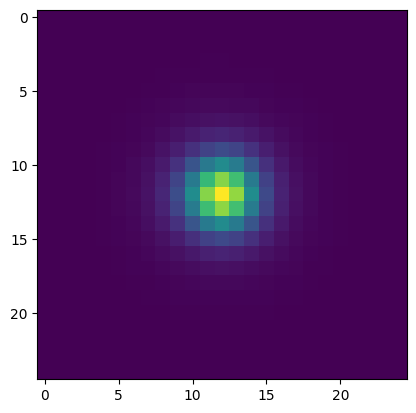

In [16]:
import matplotlib.pyplot as plt
plt.imshow(psf_array)